# Assemble green function with AE event:  remove response
2022.02.15 Kurama Okubo

2022.05.08 update for fb03-045

2022.07.29 update for removal response using PAZ

2022.12.05 update for removal response with preamp, AE sensor and the source factor obtained from the ball drop.

2023.07.24 update for fb03-087

2023.10.22 update for fb03-087 multiple events

2024.2.6 update for master plot: replaced the ball drop gain model to model 4 including the aperture effect

2024.6.9 update save different stream with more sensors.

2024.10.31 update for the merged catalog

## Work flow

1. Read isocoord pickle associated with stations
2. Read meta data
3. Read synthetic waveform
4. Preprocess (unscale using gain to the observation **& remove response**)
4. Save pickle

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from obspy.signal.invsim import paz_to_freq_resp

from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

%load_ext autoreload
%autoreload 2

from remove_resp_digitalfilt import *

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

    
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

from obspy.core.utcdatetime import UTCDateTime  
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
#Parameters
simulationtitle = 'MTinv_fb03-087' # to read sac, set simulation title used in Input.inf of OpenSWPC

balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

# rootdir for removal resp analysis
rootdir = "./"
# Sensor gain
fi_balldropgain = rootdir+f'../../Calibration/SensorCoupling_BallDrop/data/DATA_surfaceeffect_Aij_Case2/master_gain_model{balldrop_model}.csv'
# fi_balldropgain = rootdir+f'../data/resp/master_gain_model3.csv' # debug
fi_AEresp = rootdir+'../../Calibration/AEsensor_Calibration/AEsensor_Calibration_ARX/data/AE_resp_dataandcoef_fronttop.mat'
# fi_AEresp = rootdir+'../data/resp/debug_AE_resp_dataandcoef_fronttop.mat' # debug
fi_preamp = rootdir+'../data/resp/preamp_mistras_resp.mat'
figdir = "../figure"

fontsize = 12
vmean = 6200
fs = 1e7; # sampling frequency

# Pre-amplification
preamp_dB = 40 # [dB]
preamp_V = 10 ** (preamp_dB/20)
preamp_V

100.0

# Test of removal response using metal block test
We first test to remove the response using metal block data.
The coefficients of PAZ are estimated using matlab code.

In [3]:
D = sio.loadmat(fi_AEresp);
D.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AIC', 'Na', 'Nb', 'k', 'p', 'tf_a', 'tf_b', 'u_input_raw', 'u_normfact', 'y_output_raw', 'z'])

In [4]:
np.squeeze(D["u_input_raw"])

array([1.98263840e-05, 2.47079860e-05, 2.48935806e-05, ...,
       2.91986732e-06, 1.87184595e-05, 1.40819017e-05])

In [5]:
# compile trace
st_mb = Stream()
tr_u = Trace()
tr_u.stats.starttime = datetime.datetime(2022,7,29)
tr_u.stats.sampling_rate = fs
tr_u.stats.network = "N"
tr_u.stats.station = "IN"
tr_u.stats.channel = "Z"
tr_u.data = np.squeeze(D["u_input_raw"])

tr_y = tr_u.copy()
tr_y.stats.station = "OUT"
tr_y.stats.channel = "Z"
tr_y.data = np.squeeze(D["y_output_raw"])


In [6]:
tr_y.stats

         network: N
         station: OUT
        location: 
         channel: Z
       starttime: 2022-07-29T00:00:00.00000000Z
         endtime: 2022-07-29T00:00:00.00010000Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 1001
           calib: 1.0

In [7]:
# remove response using the function
poles_AE = np.squeeze(D["p"])
zeros_AE = np.squeeze(D["z"])
scale_fac_AE = np.squeeze(D["k"])
u_normfact_AE = np.squeeze(D["u_normfact"])
pre_filt = (1e4, 2e4, 1e6, 2e6)
water_level = 60

# debug
# scale_fac_AE /= u_normfact_AE

tr_removed = remove_resp_digitalfilt(tr_y, poles_AE, zeros_AE, scale_fac_AE, pre_filt=pre_filt, water_level=60, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=False)

In [8]:
freqmin = 6e4
freqmax = 3e5

tr_u_filtered = tr_u.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)
tr_inv_filtered = tr_removed.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)
tr_y_filtered =  tr_y.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)

(0.0, 100.0)

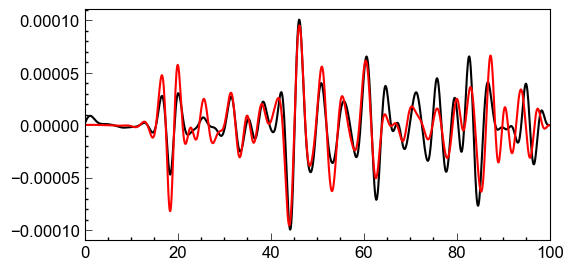

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u_filtered.times()*1e6
ax.plot(tvec, tr_u_filtered.data, "k-", label="LDV")
ax.plot(tvec, tr_inv_filtered.data, "r-", label="inverted")
# ax.plot(tvec, tr_y_filtered.data/5e4, "b--", label="inverted")
ax.set_xlim([0, 100])



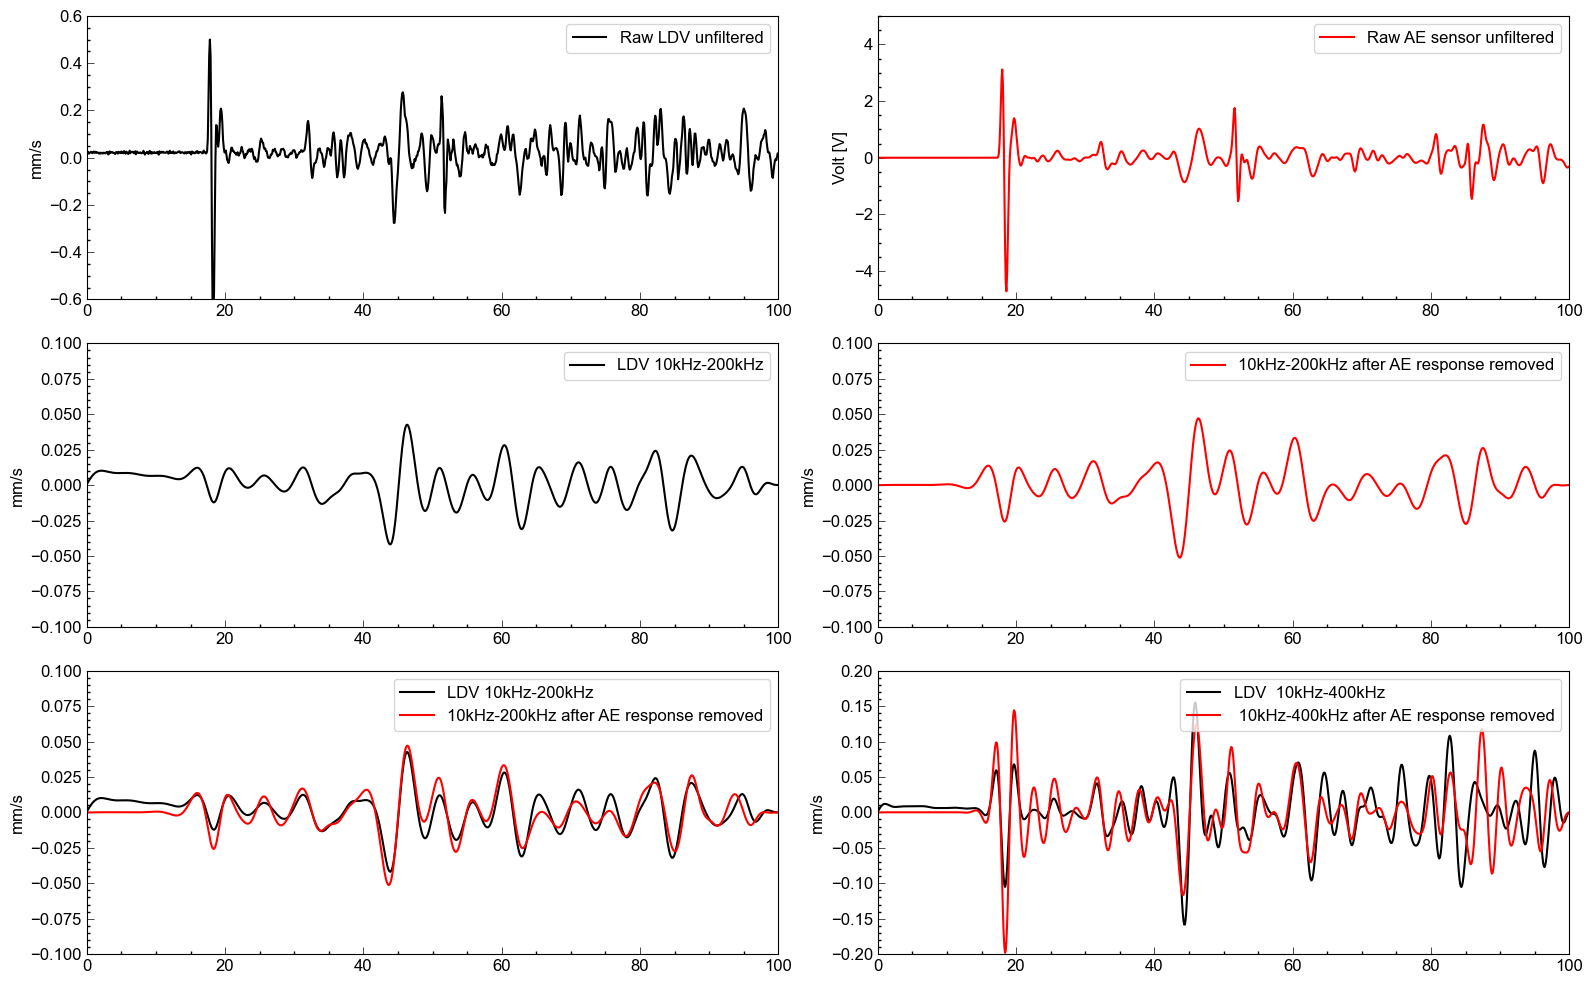

In [10]:
freqmin = 1e4
freqmax = 2e5
freqmax_high = 4e5

fig, axs = plt.subplots(3, 2, figsize=(16, 10))
tvec = tr_u_filtered.times()*1e6

axs[0,0].plot(tvec, tr_u.data*1e3, "k-", label="Raw LDV unfiltered")
axs[0,0].set_ylim([-0.6, 0.6])
axs[0,0].set_ylabel("mm/s")

axs[0,1].plot(tvec, tr_y.data, "r-", label="Raw AE sensor unfiltered")
axs[0,1].set_ylim([-5.0, 5.0])
axs[0,1].set_ylabel("Volt [V]")

axs[1,0].plot(tvec, tr_u.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).data*1e3, "k-", label=f"LDV {int(freqmin/1e3)}kHz-{int(freqmax/1e3)}kHz")
axs[1,0].set_ylim([-0.1, 0.1])
axs[1,0].set_ylabel("mm/s")

axs[1,1].plot(tvec, tr_removed.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).data*1e3, "r-",
                                          label=f"{int(freqmin/1e3)}kHz-{int(freqmax/1e3)}kHz after AE response removed")
axs[1,1].set_ylim([-0.1, 0.1])
axs[1,1].set_ylabel("mm/s")

axs[2,0].plot(tvec, tr_u.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).data*1e3, "k-", label=f"LDV {int(freqmin/1e3)}kHz-{int(freqmax/1e3)}kHz")
axs[2,0].plot(tvec, tr_removed.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).data*1e3, "r-",label=f"{int(freqmin/1e3)}kHz-{int(freqmax/1e3)}kHz after AE response removed")
axs[2,0].set_ylim([-0.1, 0.1])
axs[2,0].set_ylabel("mm/s")

axs[2,1].plot(tvec, tr_u.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax_high, corners=3, zerophase=True).data*1e3, "k-", label=f"LDV  {int(freqmin/1e3)}kHz-{int(freqmax_high/1e3)}kHz")
axs[2,1].plot(tvec, tr_removed.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax_high, corners=3, zerophase=True).data*1e3, "r-",label=f" {int(freqmin/1e3)}kHz-{int(freqmax_high/1e3)}kHz after AE response removed")
axs[2,1].set_ylim([-0.2, 0.2])
axs[2,1].set_ylabel("mm/s")


for ax_h in axs:
    for ax in ax_h:
        ax.legend(loc=1)
        ax.set_xlim([0, 100])
        
plt.tight_layout()
# plt.savefig(figdir+"/LDVandAE_comparison.png", dpi=300)


## Plot poles and zeros

Text(0.5, 1.0, 'Npoles:24 Nzeros:11')

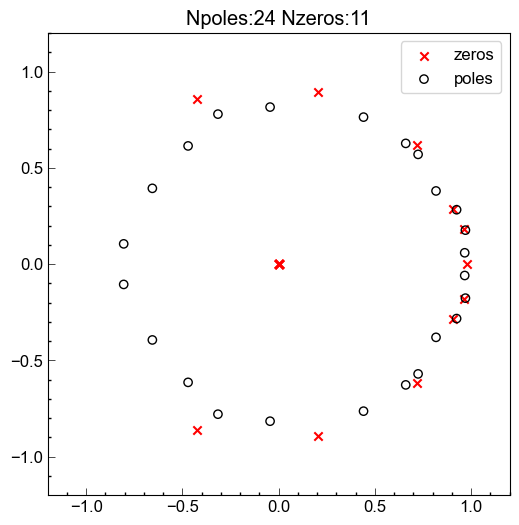

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

poles_AE.size, np.count_nonzero(zeros_AE)

ax.scatter([np.real(x) for x in zeros_AE], [np.imag(x) for x in zeros_AE], label="zeros",
           marker="x", c="r")
ax.scatter([np.real(x) for x in poles_AE], [np.imag(x) for x in poles_AE], label="poles",
           marker="o", fc="None", ec="k")
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_aspect('equal')
ax.legend(loc=1)
ax.set_title(f"Npoles:{poles_AE.size} Nzeros:{np.count_nonzero(zeros_AE)}")

# Bode plot

In [12]:
_, freqs, freq_domain_taper, data_after_freqtapered, freq_response_forward, freq_response = remove_resp_digitalfilt(tr_y, poles_AE, zeros_AE, scale_fac_AE, pre_filt=pre_filt, water_level=60, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=True)

In [13]:
len(freqs)

1003

In [14]:
# compute G from just dividing y from u
from obspy.signal.util import _npts2nfft
nfft = _npts2nfft(tr_y.stats.npts)
U = np.fft.rfft(tr_u.data, n=nfft)
Y = np.fft.rfft(tr_y.data, n=nfft)
g_freqs = np.fft.rfftfreq(nfft, d=1/fs)
g_est = Y/U

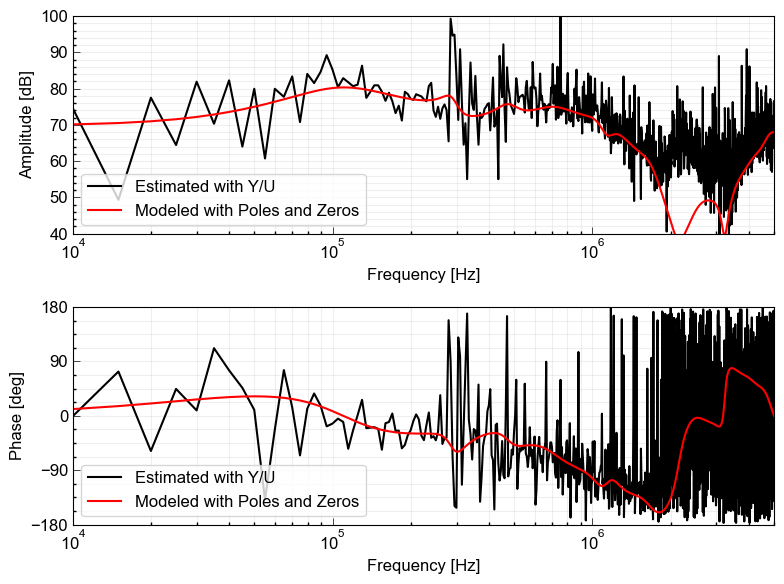

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
xlimit = [10e3, 5e6]

axs[0].grid(True, which="both", ls="-", alpha=0.2)

axs[0].semilogx(g_freqs, 20 * np.log10(abs(g_est)), "k-", label="Estimated with Y/U")
axs[0].semilogx(freqs, 20 * np.log10(abs(freq_response_forward)), "r-", label="Modeled with Poles and Zeros")

axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_ylabel("Amplitude [dB]")
axs[0].set_xlim(xlimit)
axs[0].set_ylim([40, 100])
axs[0].legend(loc=3)


# angles_gest = np.unwrap(np.angle(g_est)) # unwrap the angle to make it continuous; not applied for this figure
# angles_paz = np.unwrap(np.angle(freq_response_forward))
angles_gest = np.angle(g_est)
angles_paz = np.angle(freq_response_forward)

axs[1].grid(True, which="both", ls="-", alpha=0.2)

axs[1].semilogx(g_freqs, np.rad2deg(angles_gest), 'k', label="Estimated with Y/U")
axs[1].semilogx(freqs, np.rad2deg(angles_paz), 'r', label="Modeled with Poles and Zeros")

axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel('Phase [deg]')
axs[1].set_ylim([-180, 180])
axs[1].set_yticks([-180, -90, 0, 90, 180])
axs[1].set_xlim(xlimit)
axs[1].legend(loc=3)

plt.tight_layout()
# plt.savefig(figdir+"/AEsensor_bode.png", dpi=300)


In [16]:
ax

<AxesSubplot:title={'center':'Npoles:24 Nzeros:11'}>

# Read gain factor obtained from ball drop test

In [17]:
df_gain = pd.read_csv(fi_balldropgain, index_col=0)
df_gain.loc[df_gain['AEsensor'] == "OL01"]["gainfactor"].values # this includes 40dB of pre-amplification
df_gain

,AEsensor,gainfactor
0,OL01,0.464981
1,OL02,0.394665
2,OL03,0.709499
3,OL04,0.572041
4,OL05,0.634546
5,OL06,0.421090
6,OL07,0.913089
7,OL08,0.972009
8,OL09,0.911681
9,OL10,0.837128


In [18]:
df_gain[df_gain["AEsensor"] == "OL03"]["gainfactor"].values[0]

0.709499007818267

# Read response of preamp filter

In [19]:
A = sio.loadmat(fi_preamp);
print(A.keys())

tvec = np.squeeze(A["tvec"]) # PAZ of the model for G20/G40
u_input_40 = np.squeeze(A["u_input_40"]) # PAZ of the model for G20/G40
y_output_20 = np.squeeze(A["y_output_20"]) # PAZ of the model for G20/G40
y_output_60 = np.squeeze(A["y_output_60"]) # PAZ of the model for G20/G40

PAZ_param = dict()

M20 = A["PAZ20"] # PAZ of the model for G20/G40
PAZ_param["p_20"] = np.squeeze(M20['p'][0][0])
PAZ_param["z_20"] = np.squeeze(M20['z'][0][0])
PAZ_param["k_20"] = np.squeeze(M20['k'][0][0])

M60 = A["PAZ60"] # PAZ of the model for G60/G40
PAZ_param["p_60"] = np.squeeze(M60['p'][0][0])
PAZ_param["z_60"] = np.squeeze(M60['z'][0][0])
PAZ_param["k_60"] = np.squeeze(M60['k'][0][0])


dict_keys(['__header__', '__version__', '__globals__', 'PAZ20', 'PAZ60', 'tvec', 'u_input_40', 'y_output_20', 'y_output_60'])


In [21]:
# pickle event waveform directory
eventdatadir ='../data/04_2_AE_obs_isocoord_forFig2'

# greens function data directory 

greendatadir =  rootdir+'./05_numericalsimulation/case_gougepatch_fb03-087_cluster_cp6200_cs3600_v7_mergedcatalog/out/green/S00'

# output datadir
outputdir = f"../data/06_2_assemble_gf_model{balldrop_model}"

# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'


In [22]:
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [23]:
# read gindex table
df_gindextable = pd.read_csv("../data/datacsv/gindex_table.csv", index_col=0)
df_gindextable

,index,gid
0,OL06__fb03-087__0004,0
1,OL06__fb03-087__0009,1
2,OL06__fb03-087__0018,2
3,OL06__fb03-087__0019,3
4,OL06__fb03-087__0020,4
...,...,...
259,OL24__fb03-087__0120,259
260,OL24__fb03-087__0126,260
261,OL24__fb03-087__0128,261
262,OL24__fb03-087__0129,262


In [24]:
# read observation casename  table
df_iso_all = pd.read_csv("../data/datacsv/AEevents_isocoord_forFig2.csv", index_col=0)
# reassemble event id 
event_cases = np.unique(df_iso_all["datacase"])
df_iso_all.head()

,OL,datacase,xs,ys,zs,xi,eta,zeta,xi1,eta1,zeta1,incidentangle,azimuth,rlen_sourcedist,llen
OL03__fb03-087__0004,OL03,fb03-087__0004,0.64,0.05,0.07,1.7475,0.00505,0,1.1075,-0.04495,0,87.680441,87.675817,1.110620,1.108412
OL03__fb03-087__0009,OL03,fb03-087__0009,0.64,0.05,0.07,1.7425,0.00375,0,1.1025,-0.04625,0,87.602666,87.597844,1.105688,1.103470
OL03__fb03-087__0018,OL03,fb03-087__0018,0.64,0.05,0.07,1.7460,0.00375,0,1.1060,-0.04625,0,87.610213,87.605437,1.109178,1.106967
OL03__fb03-087__0019,OL03,fb03-087__0019,0.64,0.05,0.07,1.7425,0.00300,0,1.1025,-0.04700,0,87.563836,87.558937,1.105719,1.103501
OL03__fb03-087__0020,OL03,fb03-087__0020,0.64,0.05,0.07,1.7460,0.00325,0,1.1060,-0.04675,0,87.584408,87.579580,1.109199,1.106988


In [25]:
event_cases

array(['fb03-087__0004', 'fb03-087__0009', 'fb03-087__0018',
       'fb03-087__0019', 'fb03-087__0020', 'fb03-087__0021',
       'fb03-087__0024', 'fb03-087__0027', 'fb03-087__0030',
       'fb03-087__0031', 'fb03-087__0037', 'fb03-087__0038',
       'fb03-087__0040', 'fb03-087__0043', 'fb03-087__0044',
       'fb03-087__0049', 'fb03-087__0050', 'fb03-087__0052',
       'fb03-087__0055', 'fb03-087__0059', 'fb03-087__0061',
       'fb03-087__0062', 'fb03-087__0069', 'fb03-087__0072',
       'fb03-087__0075', 'fb03-087__0076', 'fb03-087__0077',
       'fb03-087__0081', 'fb03-087__0085', 'fb03-087__0088',
       'fb03-087__0089', 'fb03-087__0095', 'fb03-087__0099',
       'fb03-087__0100', 'fb03-087__0102', 'fb03-087__0109',
       'fb03-087__0110', 'fb03-087__0111', 'fb03-087__0118',
       'fb03-087__0120', 'fb03-087__0126', 'fb03-087__0128',
       'fb03-087__0129', 'fb03-087__0131'], dtype=object)

In [26]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())

## Assemble observation and synthetic waveform

In [27]:
# Read observation
pre_filt = (1e4, 2e4, 1e6, 2e6) # prefilter for the remove_resp
water_level = 60 # waterlevel [dB] for the remove_resp

for event_case in tqdm(event_cases):
# event_case = event_cases[1]

    foname = os.path.join(outputdir, "{}_AEwaveform_forFig2.pickle".format(event_case)) 

    # if os.path.exists(foname):
    #     print("{}_bdwaveform.pickle already exists. skip this case.".format(event_case))
    #     continue

    df_iso_st = df_iso_all[df_iso_all.datacase==event_case]
    xlimit = [-0.5, 3]
    ylimit = [-1.0, 1.0]

    # if not df_iso_st:
    #     print("{}_bdwaveform.pickle already exists. skip this case.".format(stnm))
    #     continue

    df_iso_st

    st_eventsta = Stream()

    #---Start assembling each AE event---#
    for dataind in df_iso_st.index:
        #---Read observation data---#
        stnm, runID, event_id = dataind.split('__')

        tr_obs_trim = read(eventdatadir+"/obs_isocoord_{}_forFig2.pickle".format(dataind))[0]
        tr_obs_trim.stats.dataindex = dataind
        # rename channel
        tr_obs_trim.stats.channel = 'OZ' # 'OZ: Observatoin in Z direction with sidecoord_seg

        #--------------------------------------------------#
        #---Remove the instrumental response---#
        #--------------------------------------------------#
        # Stage 3: deconvolve preamp filter (G60/G40)
        # Stage 2: deconvolve AE sensor + preamp +40dB
        # Stage 1: rescale with the ball-drop calibration: NOTE: the aperture effect should be removed during the waveform fitting
        
        # Stage 3:
        if preamp_dB == 60:
            tr_stage3 = remove_resp_digitalfilt(tr_obs_trim, PAZ_param["p_60"], PAZ_param["z_60"], PAZ_param["k_60"],
                                            pre_filt=pre_filt, water_level=water_level, zero_mean=True, taper=True, taper_fraction=0.05, detrend=True, debug=False)
        elif preamp_dB == 20:
            tr_stage3 = remove_resp_digitalfilt(tr_obs_trim, PAZ_param["p_20"], PAZ_param["z_20"], PAZ_param["k_20"],
                                            pre_filt=pre_filt, water_level=water_level, zero_mean=True, taper=True, taper_fraction=0.05, detrend=True, debug=False)
            
        else:
            # no application for stage 3
            tr_stage3 = tr_obs_trim
            
        # Stage 2:
        tr_stage2 = remove_resp_digitalfilt(tr_stage3, poles_AE, zeros_AE, scale_fac_AE, # update: u_normfact is already included in scale_fac_AE
                                            pre_filt=pre_filt, water_level=water_level, zero_mean=True, taper=True, taper_fraction=0.05, detrend=True, debug=False)
        
        # Stage 1: 
        tr_stage1 = tr_stage2.copy()
        sensorgain = df_gain[df_gain["AEsensor"] == stnm]["gainfactor"].values[0]
        print(sensorgain)
        tr_stage1.data = tr_stage2.data/sensorgain
        tr_stage1.stats.location="stage1"
        st_eventsta.append(tr_stage1)

        
        # append to event stream both with and without instrumental response removal
        tr_obs_trim_raw = tr_obs_trim.copy()
        tr_obs_trim_raw.stats.location="raw"
        st_eventsta.append(tr_obs_trim_raw)

        tr_obs_trim_stage3 = tr_stage3.copy()
        tr_obs_trim_stage3.stats.location="stage3"
        st_eventsta.append(tr_obs_trim_stage3)

        tr_obs_trim_stage2 = tr_stage2.copy()
        tr_obs_trim_stage2.stats.location="stage2"
        st_eventsta.append(tr_obs_trim_stage2)
        #--------------------------------------------------#

        # Skip the synthetic green's functions
#         #---read green's tensor---#
#         # read synthetic green's function
#         gid = df_gindextable[df_gindextable['index'] == dataind]['gid'].values[0]
#         finame_syn = '{}/{}__{:08d}__S00__z__m*__.sac'.format(greendatadir, simulationtitle, gid) # Green's tensor in [nm/s]
#         print(finame_syn, gid)
#         trs_syn = read(finame_syn, format="SAC")

#         # restore stats
#         for tr_syn in trs_syn:
#             tr_syn.stats.network = 'OL'
#             tr_syn.stats.station = stnm
#             tr_syn.stats.location = 'GF'
#         #     tr_syn.stats.channel = '' 
#             tr_syn.stats.dataindex = dataind

#             # rescale source scaling and convert from nm to m
#             tr_syn.data = tr_syn.data/1e9
#             # manipulate start and endtime
#             # 1. zero pad pretriger and windowlen
#             # 2. change starttime

#             T0 = 0.0 # Origin time used in OpenSWPC

#             st_tmp = tr_syn.stats.starttime
#             pt = timedelta(milliseconds = tr_obs_trim.stats.pretrigger)
#             wt = timedelta(milliseconds = tr_obs_trim.stats.windowlen)
#             ot = timedelta(milliseconds = T0)

#             starttime_tmp = st_tmp+ot-pt
#             endtime_tmp = st_tmp+ot+wt

#             tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
#             tr_syn_trim.trim(starttime_tmp, endtime_tmp, pad=True, fill_value=0.0)
#             tr_syn_trim.stats.starttime =  tr_obs_trim.stats.starttime

#             st_eventsta.append(tr_syn_trim)

    # Save Stream containing a set of observation and synthetic waveform
    if not os.path.exists(outputdir):
        os.makedirs(outputdir) 
    st_eventsta.write(foname, format="pickle")

  2%|█                                               | 1/44 [00:00<00:06,  6.26it/s]

0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068


  7%|███▎                                            | 3/44 [00:00<00:05,  7.02it/s]

0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981


 11%|█████▍                                          | 5/44 [00:00<00:05,  7.69it/s]

0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183


 16%|███████▋                                        | 7/44 [00:00<00:04,  8.49it/s]

0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528


 23%|██████████▋                                    | 10/44 [00:01<00:03,  9.04it/s]

1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277


 27%|████████████▊                                  | 12/44 [00:01<00:03,  9.51it/s]

1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333


 32%|██████████████▉                                | 14/44 [00:01<00:03,  9.72it/s]

0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679


 36%|█████████████████                              | 16/44 [00:01<00:02, 10.10it/s]

0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183


 41%|███████████████████▏                           | 18/44 [00:01<00:02, 10.32it/s]

0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704


 45%|█████████████████████▎                         | 20/44 [00:01<00:02, 10.40it/s]

0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862


 55%|█████████████████████████▋                     | 24/44 [00:02<00:01, 10.61it/s]

0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267


 59%|███████████████████████████▊                   | 26/44 [00:02<00:01, 10.59it/s]

0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785


 64%|█████████████████████████████▉                 | 28/44 [00:02<00:01, 10.90it/s]

0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713


 68%|████████████████████████████████               | 30/44 [00:02<00:01, 11.15it/s]

1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267


 73%|██████████████████████████████████▏            | 32/44 [00:03<00:01, 11.35it/s]

0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311


 77%|████████████████████████████████████▎          | 34/44 [00:03<00:00, 11.18it/s]

0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896


 82%|██████████████████████████████████████▍        | 36/44 [00:03<00:00, 10.99it/s]

1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586


 86%|████████████████████████████████████████▌      | 38/44 [00:03<00:00,  8.40it/s]

0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896


 91%|██████████████████████████████████████████▋    | 40/44 [00:03<00:00,  9.00it/s]

1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082


 95%|████████████████████████████████████████████▊  | 42/44 [00:04<00:00,  9.65it/s]

1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851
0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862
0.709499007818267
0.572041480477333
0.634546413526172
0.421090419541679
0.913089430211785
0.972009279647311
0.9116813516981
0.837128216228068
0.628677475822183
0.762538467646586
0.884037561599615
0.842488415005704
0.92585545586896
1.07259224272851


100%|███████████████████████████████████████████████| 44/44 [00:04<00:00,  9.49it/s]

0.991050073723713
1.02493577612277
1.19121495953082
1.01815870455528
1.14014538495862


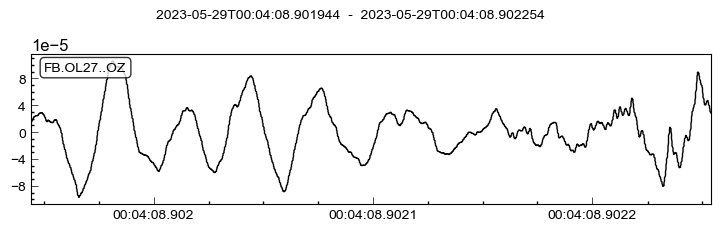

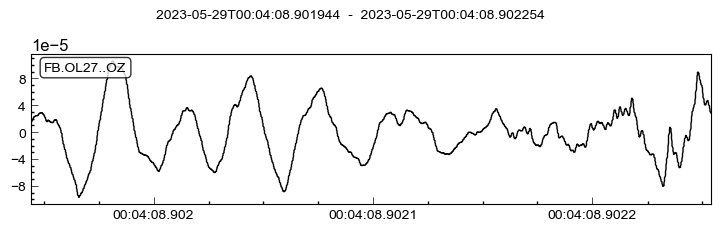

In [28]:
tr_stage2.plot()

In [29]:
# print(st_eventsta.__str__(extended=True))

In [30]:
event_case

'fb03-087__0131'

In [31]:
# plot comparison with and without instrumental response removal
event_case = "fb03-087__0072"
stnm = "OL07"
finame = os.path.join(outputdir, "{}_AEwaveform_forFig2.pickle".format(event_case)) 
st_event = read(finame) # this contains observation and green's function within a thresholded distance
tr_wrem = st_event.select(station=stnm, location="stage1", channel="OZ")[0]
tr_norem = st_event.select(station=stnm, location="raw", channel="OZ")[0]

In [32]:
print(st_event.__str__(extended=True))

76 Trace(s) in Stream:
FB.OL03.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.raw.OZ    | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.stage3.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.stage2.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.raw.OZ    | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage3.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage2.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL05.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z

In [33]:
print(st_event.__str__(extended=True))

76 Trace(s) in Stream:
FB.OL03.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.raw.OZ    | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.stage3.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL03.stage2.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.raw.OZ    | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage3.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage2.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL05.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z

In [34]:
# stnm_list = np.unique([tr.stats.station for tr in st_event])
# manually rearrange with distance from source
stnm_list = ["OL24", "OL08", "OL23", "OL07", "OL22", "OL06"]


In [35]:
pretrigger = tr_wrem.stats

[-0.2, 0.2]
[-0.2, 0.2]
[-0.4, 0.4]
[-0.4, 0.4]
[-0.2, 0.2]
[-0.1, 0.1]


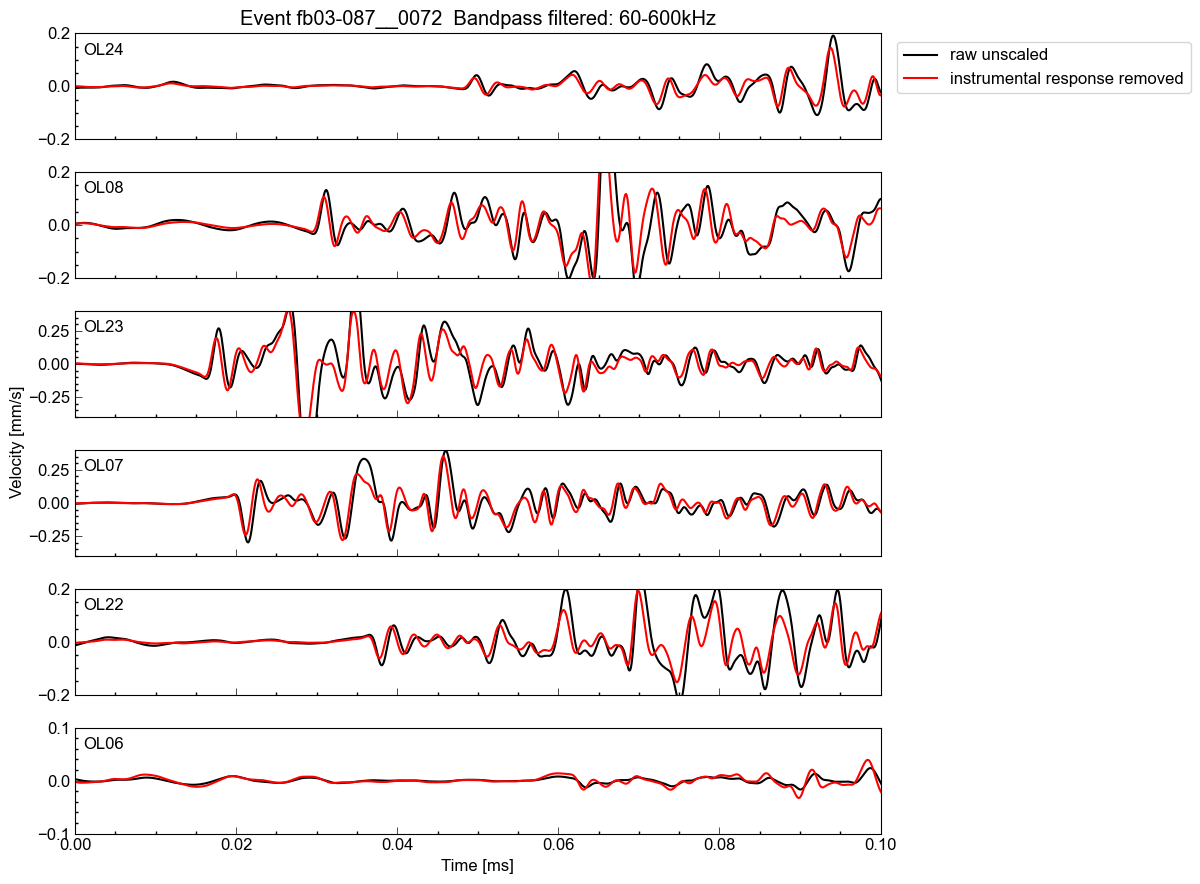

In [36]:
Nsensor = len(stnm_list)
fig, axs = plt.subplots(Nsensor, 1, figsize=(12, 9), sharex=True)

freqmin = 6e4
freqmax = 6e5
xlimit = [0, 0.1]
ylimits =[0.2, 0.2, 0.4, 0.4, 0.2, 0.1] 
scale_fac = 5000 # emperical scaling factor; which is estimated from ball drop test

for i, stnm in enumerate(stnm_list):

    tr_wrem = st_event.select(station=stnm, location="stage1", channel="OZ")[0]
    tr_norem = st_event.select(station=stnm, location="raw", channel="OZ")[0]

    # apply bandpass filter

    tr_wrem_filtered = tr_wrem.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=2, zerophase=True)
    tr_norem_filtered = tr_norem.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=2, zerophase=True)

    # 1. plot entire trace
    tvec = (tr_wrem_filtered.times())*1e3 - tr_wrem_filtered.stats.pretrigger
    axs[i].plot(tvec, tr_norem_filtered.data*1e3/scale_fac, "k-")
    axs[i].plot(tvec, tr_wrem_filtered.data*1e3, "r-")
    axs[i].set_xlim(xlimit)

    # set ylim
    fs = tr_wrem_filtered.stats.delta 
    tmax_ind = np.min(np.where(tvec>xlimit[1]))
    ylim_amp_filt = 1.2*np.maximum(np.max(np.abs(tr_norem_filtered.data[:tmax_ind]*1e3)), np.max(np.abs(tr_wrem_filtered.data[:tmax_ind]*1e3)))
#     axs[i].set_ylim([-ylim_amp_filt, ylim_amp_filt])
    axs[i].set_ylim([-ylimits[i], ylimits[i]])
    print([-ylimits[i], ylimits[i]])
    axs[i].text(0.01, 0.8, f"{stnm}", transform=axs[i].transAxes)

axs[0].set_title(r"Event {}  Bandpass filtered: {:.0f}-{:.0f}kHz".format(event_case, freqmin/1e3, freqmax/1e3))
fig.text(0.0, 0.5, 'Velocity [mm/s]', va='center', rotation='vertical')

axs[-1].set_xlabel("Time [ms]")

axs[0].legend(["raw unscaled", "instrumental response removed"], bbox_to_anchor=(1.01, 1.0), loc="upper left")

plt.tight_layout()
plt.savefig(figdir+"/comparison_response_removal_event{}_forFig2.png".format(event_case), dpi=300)

        

In [37]:
tr_obs_trim.stats.starttime

2023-05-29T00:04:08.90194400Z